# AGE AND GENDER PREDICTION ON UTKFACE.

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/utkface-new/UTKFace/26_0_2_20170104023102422.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/22_1_1_20170112233644761.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/21_1_3_20170105003215901.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/28_0_0_20170117180555824.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/17_1_4_20170103222931966.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/44_0_3_20170119201022260.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/35_0_2_20170116182734834.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/76_0_0_20170104213515132.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/36_1_0_20170116165722892.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/34_0_3_20170119200815948.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/18_1_0_20170104022856102.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/40_1_1_20170113011948248.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/45_0_0_20170117180013541.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/26_1_1_20170117153641469.jpg.c

# Dataset Information

UTKFace dataset is a large-scale face dataset with long age span (range from 0 to 116 years old). The dataset consists of over 20,000 face images with annotations of age, gender, and ethnicity. The images cover large variation in pose, facial expression, illumination, occlusion, resolution, etc. This dataset could be used on a variety of tasks, e.g., face detection, age estimation, age progression/regression, landmark localization, etc.


The objective of the project is to detect gender and age using facial images. Convolutional Neural Network is used to classify the images. There are 2 output types namely, gender(M or F) and age.



The UTKFace dataset is a large-scale face dataset consisting of over 20,000 images. The images cover a wide range of ages and races and include both males and females.

Using this dataset, I will be attempting to create a model capable of predicting the age and gender of an individual. I will be using part one of the cropped variations of the images, of which there are almost 10,000. However, I will only be using the first 8000 of these images due to memory limitations.

# Table of Contents

1. Imports                                                                    
2. Loading Data
3. Visualising Data
4. Train Test Split
5. Creating the Model
6. Training the Models
7. Evaluating the Models


# 1. Import Python Libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# 2. Loading the UTKFace Dataset

In [4]:
images = []
ages = []
genders = []

for i in os.listdir('../input/utkface-new/crop_part1/')[0:8000]:
    split = i.split('_')
    ages.append(int(split[0]))
    genders.append(int(split[1]))
    images.append(Image.open('../input/utkface-new/crop_part1/' + i))

In [5]:
images = pd.Series(list(images), name = 'Images')
ages = pd.Series(list(ages), name = 'Ages')
genders = pd.Series(list(genders), name = 'Genders')

df = pd.concat([images, ages, genders], axis=1)
df

Images  Ages  Genders
0     <PIL.JpegImagePlugin.JpegImageFile image mode=...    26        0
1     <PIL.JpegImagePlugin.JpegImageFile image mode=...    21        1
2     <PIL.JpegImagePlugin.JpegImageFile image mode=...    17        1
3     <PIL.JpegImagePlugin.JpegImageFile image mode=...    76        0
4     <PIL.JpegImagePlugin.JpegImageFile image mode=...    18        1
...                                                 ...   ...      ...
7995  <PIL.JpegImagePlugin.JpegImageFile image mode=...     3        0
7996  <PIL.JpegImagePlugin.JpegImageFile image mode=...    28        0
7997  <PIL.JpegImagePlugin.JpegImageFile image mode=...    10        0
7998  <PIL.JpegImagePlugin.JpegImageFile image mode=...     8        1
7999  <PIL.JpegImagePlugin.JpegImageFile image mode=...    22        0

[8000 rows x 3 columns]

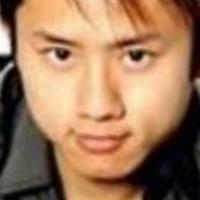

26 0


In [6]:
display(df['Images'][0])
print(df['Ages'][0], df['Genders'][0])

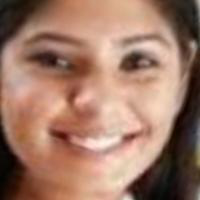

21 1


In [7]:
display(df['Images'][1])
print(df['Ages'][1], df['Genders'][1])

So 0 corresponds to male, 1 corresponds to female.

# 3. Visualising & Preparing Data

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


<AxesSubplot:xlabel='Ages', ylabel='Density'>

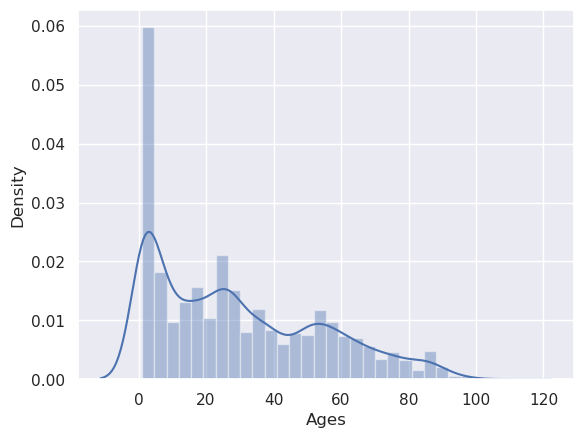

In [8]:
sns.set_theme()
sns.distplot(df['Ages'],kde=True, bins=30)

Too many faces of people between 0 and 4 years old. The model would fit too well to these ages and not enough to the other ages. To resolve this I'm only going to include a third of the images between these ages.

In [9]:
under4s = []

for i in range(len(df)):
    if df['Ages'].iloc[i] <= 4:
        under4s.append(df.iloc[i])
under4s = pd.DataFrame(under4s)
under4s = under4s.sample(frac=0.3)

df = df[df['Ages'] > 4]

df = pd.concat([df, under4s], ignore_index = True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='Ages', ylabel='Density'>

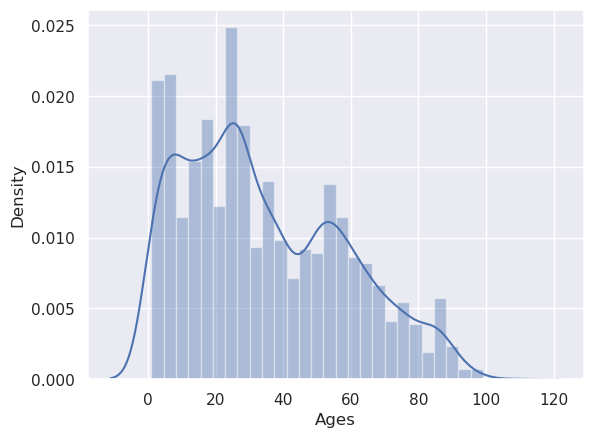

In [10]:
sns.distplot(df['Ages'],kde=True, bins=30)

This looks much better! The dataframe is more representative of the population now. However, there aren't many images of people over 80, which would cause the model to not train well enough on those ages. It's best to just remove over 80s and only have a model that can predict the ages of people under 80.

In [11]:
df = df[df['Ages'] < 80]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='Ages', ylabel='Density'>

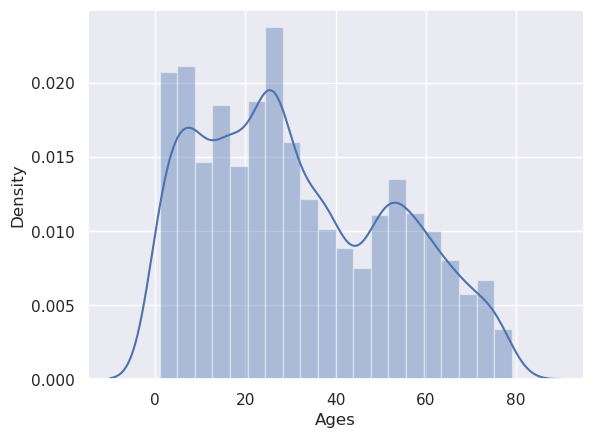

In [12]:
sns.distplot(df['Ages'],kde=True, bins=20)

<AxesSubplot:ylabel='count'>

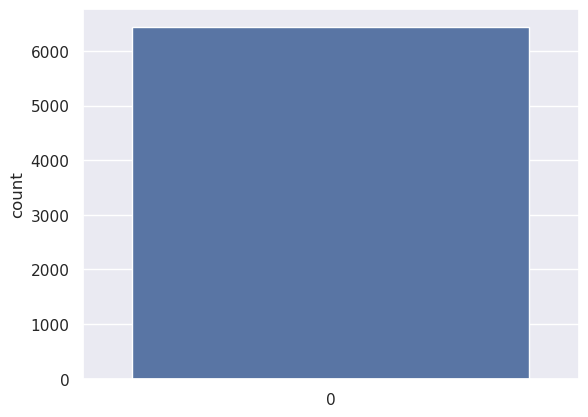

In [13]:
sns.countplot(df['Genders'])

Not sure what 3 corresponds to - both genders, no gender, unknown, or just an error in the data entry? To be safe, I am going to remove any rows where gender equals 3.

<AxesSubplot:ylabel='count'>

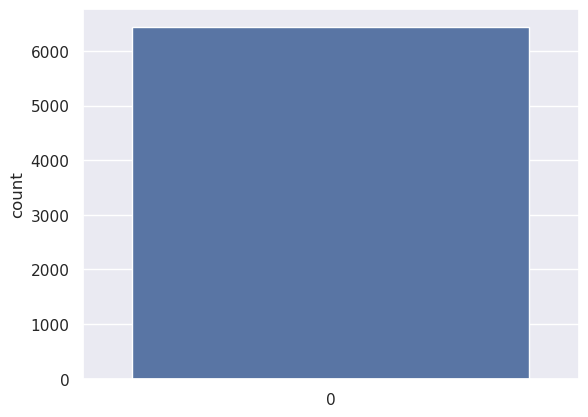

In [14]:
df = df[df['Genders'] != 3]
sns.countplot(df['Genders'])

In [15]:
x = []
y = []

for i in range(len(df)):
    df['Images'].iloc[i] = df['Images'].iloc[i].resize((200,200), Image.ANTIALIAS)
    ar = np.asarray(df['Images'].iloc[i])
    x.append(ar)
    agegen = [int(df['Ages'].iloc[i]), int(df['Genders'].iloc[i])]
    y.append(agegen)
x = np.array(x)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  """
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


# 4. Train Test Split

In [16]:
y_age = df['Ages']
y_gender = df['Genders']

x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(x, y_age, test_size=0.2, stratify=y_age)
x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(x, y_gender, test_size=0.2, stratify=y_gender)

# 5. Creating the Models


I will create two individual models - one to predict age and one to predict gender. The age model should be capable of returning continuous values which I will round to the nearest integer, and the gender model should return a binary result.

In [17]:
agemodel = Sequential()
agemodel.add(Conv2D(32, (3,3), activation='relu', input_shape=(200, 200, 3)))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Conv2D(64, (3,3), activation='relu'))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Conv2D(128, (3,3), activation='relu'))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Flatten())
agemodel.add(Dense(64, activation='relu'))
agemodel.add(Dropout(0.5))
agemodel.add(Dense(1, activation='relu'))

agemodel.compile(loss='mean_squared_error',
             optimizer=optimizers.Adam(lr=0.0001))

genmodel = Sequential()
genmodel.add(Conv2D(32, (3,3), activation='relu',  input_shape=(200, 200, 3)))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Conv2D(64, (3,3), activation='relu'))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Conv2D(128, (3,3), activation='relu'))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Flatten())
genmodel.add(Dense(64, activation='relu'))
genmodel.add(Dropout(0.5))
genmodel.add(Dense(1, activation='sigmoid'))

genmodel.compile(loss='binary_crossentropy',
             optimizer=optimizers.Adam(lr=0.0001),
             metrics=['accuracy'])

/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# 6. Training the Models

In [18]:
datagen = ImageDataGenerator(
      rescale=1./255., width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

train1 = datagen.flow(x_train_age, y_train_age, batch_size=32)

test1 = test_datagen.flow(
        x_test_age, y_test_age,
        batch_size=32)

history1 = agemodel.fit(train1, epochs=50, shuffle=True, validation_data=test1)

Epoch 1/50
161/161 [==============================] - 51s 277ms/step - loss: 584.6815 - val_loss: 468.2072
Epoch 2/50
161/161 [==============================] - 44s 274ms/step - loss: 494.6031 - val_loss: 425.8027
Epoch 3/50
161/161 [==============================] - 44s 275ms/step - loss: 457.9920 - val_loss: 377.0572
Epoch 4/50
161/161 [==============================] - 45s 277ms/step - loss: 411.7480 - val_loss: 344.8414
Epoch 5/50
161/161 [==============================] - 44s 273ms/step - loss: 372.9084 - val_loss: 312.7463
Epoch 6/50
161/161 [==============================] - 45s 279ms/step - loss: 353.8583 - val_loss: 359.2163
Epoch 7/50
161/161 [==============================] - 45s 280ms/step - loss: 340.5868 - val_loss: 280.1964
Epoch 8/50
161/161 [==============================] - 45s 282ms/step - loss: 341.0842 - val_loss: 320.7189
Epoch 9/50
161/161 [==============================] - 44s 276ms/step - loss: 328.8713 - val_loss: 268.3909
Epoch 10/50
161/161 [================

# 7. Evaluating the Models


Now to evaluate the models I am going to use some external images of celebrities. These celebrities are of a variety of ages and genders.

In [43]:
def process_and_predict(file):
    im = Image.open(file)
    width, height = im.size
    if width == height:
        im = im.resize((200,200), Image.ANTIALIAS)
    else:
        if width > height:
            left = width/2 - height/2
            right = width/2 + height/2
            top = 0
            bottom = height
            im = im.crop((left,top,right,bottom))
            im = im.resize((200,200), Image.ANTIALIAS)
        else:
            left = 0
            right = width
            top = 0
            bottom = width
            im = im.crop((left,top,right,bottom))
            im = im.resize((200,200), Image.ANTIALIAS)
            
    ar = np.asarray(im)
    ar = ar.astype('float32')
    ar /= 255.0
    ar = ar.reshape(-1, 200, 200, 3)
    
    age = agemodel.predict(ar)
    gender = np.round(genmodel.predict(ar))
    if gender == 0:
        gender = 'male'
    elif gender == 1:
        gender = 'female'
        
    print('Age:', int(age), '\n Gender:', gender)
    return im.resize((300,300), Image.Resampling.LANCZOS)

# Alyson Hannigan



1/1 [==============================] - 0s 23ms/step
Age: 41 
 Gender: female


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  """


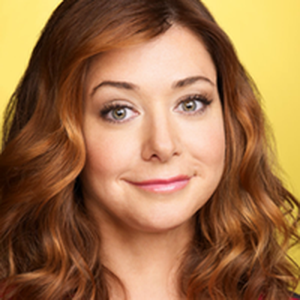

In [45]:
process_and_predict('/kaggle/input/alyson/alyson.png')

# David Boreanaz

1/1 [==============================] - 0s 21ms/step
Age: 66 
 Gender: male


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  """


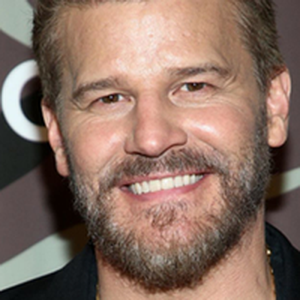

In [46]:
process_and_predict('/kaggle/input/davidboreanaz/David Boreanaz.png')

# Gaten Matarazzo



1/1 [==============================] - 0s 24ms/step
Age: 41 
 Gender: male


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  """


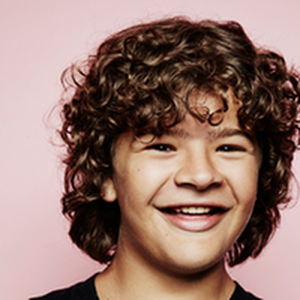

In [47]:
process_and_predict('/kaggle/input/gaten-matarazzo/Gaten Matarazzo.png')

# Jack Dylan Grazer



1/1 [==============================] - 0s 24ms/step
Age: 14 
 Gender: male


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  """


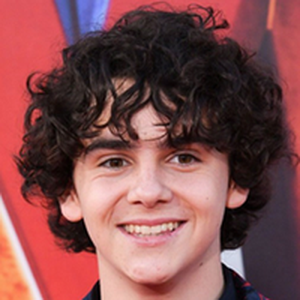

In [48]:
process_and_predict('/kaggle/input/jack-dylan-grazer/Jack Dylan Grazer.png')

# Jennifer Garner



1/1 [==============================] - 0s 23ms/step
Age: 25 
 Gender: male


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  """


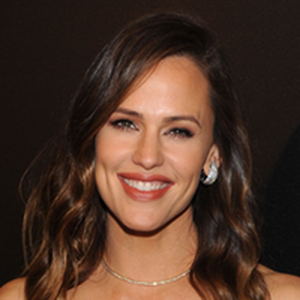

In [49]:
process_and_predict("/kaggle/input/garnerjfif/Jennifer Garner (1).png")

# Jennifer Lawrence



1/1 [==============================] - 0s 21ms/step
Age: 40 
 Gender: male


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  """


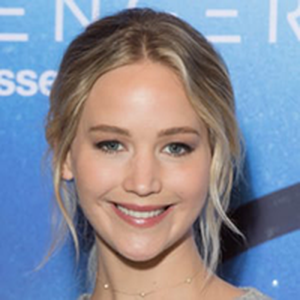

In [50]:
process_and_predict("/kaggle/input/jennifer-lawrence/Jennifer Lawrence.png")

# Meryl Streep

1/1 [==============================] - 0s 22ms/step
Age: 55 
 Gender: female


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  """


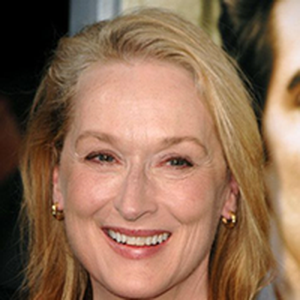

In [51]:
process_and_predict('/kaggle/input/meryl-streep/meryl.png')

# Millie Bobby Brown

1/1 [==============================] - 0s 33ms/step


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  """


Age: 16 
 Gender: female


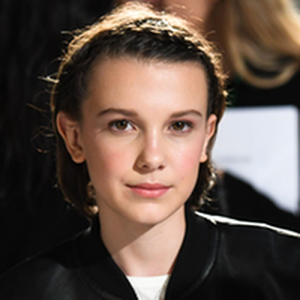

In [52]:
process_and_predict('/kaggle/input/millie-bobby-brown/Millie Bobby Brown.png')

# Morgan Freeman

1/1 [==============================] - 0s 22ms/step
Age: 81 
 Gender: male


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  """


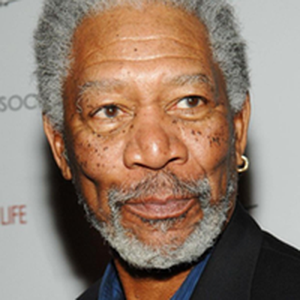

In [53]:
process_and_predict('/kaggle/input/morgan-freeman/Morgan Freeman.png')

# Oprah Winfrey

1/1 [==============================] - 0s 22ms/step
Age: 31 
 Gender: male


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  """


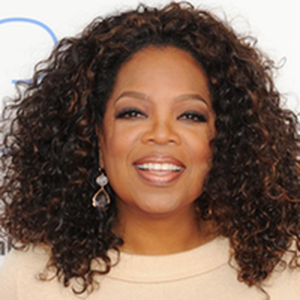

In [54]:
process_and_predict('/kaggle/input/oprah-winfrey/Oprah Winfrey.png')

# Tom Hanks

1/1 [==============================] - 0s 25ms/step
Age: 45 
 Gender: male


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  """


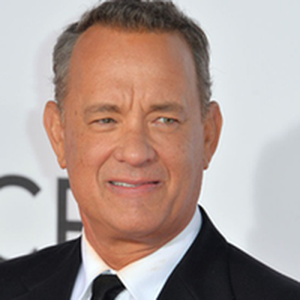

In [55]:
process_and_predict('/kaggle/input/tom-hanks/Tom Hanks.png')

# Winona Ryder



1/1 [==============================] - 0s 23ms/step
Age: 21 
 Gender: male


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  """


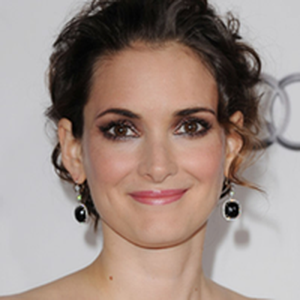

In [57]:
process_and_predict('/kaggle/input/winona/__results___56_1.png')